In [12]:

import sys
import os
import numpy as np
import mne
import matplotlib.pyplot as plt
import pickle
from collections import defaultdict


# Add the workspace root to the Python path
workspace_root = os.path.abspath("..")
if workspace_root not in sys.path:
    sys.path.append(workspace_root)
from functions import preprocess, behaviorAnalysis
id = 602 
sub = preprocess(id)
raw = sub.load_data()
events = mne.find_events(raw)
all_events = sub.get_all_events_times(id, events)
all_events
raw.notch_filter(50, fir_design='firwin', skip_by_annotation='edge')
raw.filter(l_freq=1, h_freq= 40)

Extracting EDF parameters from c:\Users\gmoha\Downloads\git\preprocessing_pipline\Data\O_602_Def_MM.bdf...
BDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 449535  =      0.000 ...   877.998 secs...
Extracting EDF parameters from c:\Users\gmoha\Downloads\git\preprocessing_pipline\Data\O_602_Def_MM.bdf...
BDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 449535  =      0.000 ...   877.998 secs...


c:\Users\gmoha\Downloads\git\preprocessing_pipline\functions.py:26: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  xyz_data = pd.read_csv(ch_location_path, delim_whitespace=True, skiprows=1, header=None)


Trigger channel Status has a non-zero initial value of 65536 (consider using initial_event=True to detect this event)
Removing orphaned offset at the beginning of the file.
108 events found on stim channel Status
Event IDs: [1 2]


c:\Users\gmoha\Downloads\git\preprocessing_pipline\functions.py:26: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  xyz_data = pd.read_csv(ch_location_path, delim_whitespace=True, skiprows=1, header=None)


Filtering raw data in 1 contiguous segment
Setting up band-stop filter from 49 - 51 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 49.38
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 49.12 Hz)
- Upper passband edge: 50.62 Hz
- Upper transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 50.88 Hz)
- Filter length: 3381 samples (6.604 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    0.7s


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 1691 samples (3.303 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    0.6s


<RawEDF | O_602_Def_MM.bdf, 129 x 449536 (878.0 s), ~442.6 MiB, data loaded>

In [ ]:
all_events = all_events.dropna()
all_trials = []
for idx, row in all_events.iterrows():
    Tnum = row['Trial']
    data = raw.copy().crop(row['defOnset']-0.2, row['Respons'] + 0.2)
    all_trials.append(data)
new_raw = mne.concatenate_raws(all_trials)

In [18]:
import mne

all_events = all_events.dropna()
all_trials = []
annotations = []

for idx, row in all_events.iterrows():
    Tnum = int(row['Trial'])
    start = row['defOnset'] - 0.2
    end = row['Respons'] + 0.2
    duration = end - start

    # Copy and crop raw data
    data = raw.copy().crop(start, end)
    
    # Create annotation
    onset_in_cropped = 0  # onset relative to start of cropped data
    annotation = mne.Annotations(onset=[onset_in_cropped],
                                 duration=[duration],
                                 description=[f'Trial {Tnum}'])
    
    # Set annotation to this segment
    data.set_annotations(annotation)

    all_trials.append(data)

# Concatenate all trials with annotations
new_raw = mne.concatenate_raws(all_trials)

# Check annotations
print(new_raw.annotations)


<Annotations | 274 segments: BAD boundary (91), EDGE boundary (91), Trial ...>


In [14]:
# Load the bad channels data
with open(os.path.join(workspace_root,'results', 'bad_channels.pkl'), "rb") as f:
    all_bad_channels = pickle.load(f)
    bad_channels = all_bad_channels[id] 
bad_channels

{'bad_by_nan': [],
 'bad_by_flat': [],
 'bad_by_deviation': ['A32'],
 'bad_by_hf_noise': ['D16'],
 'bad_by_correlation': ['A32'],
 'bad_by_SNR': [],
 'bad_by_dropout': [],
 'bad_by_ransac': [],
 'bad_all': ['A32', 'D16']}

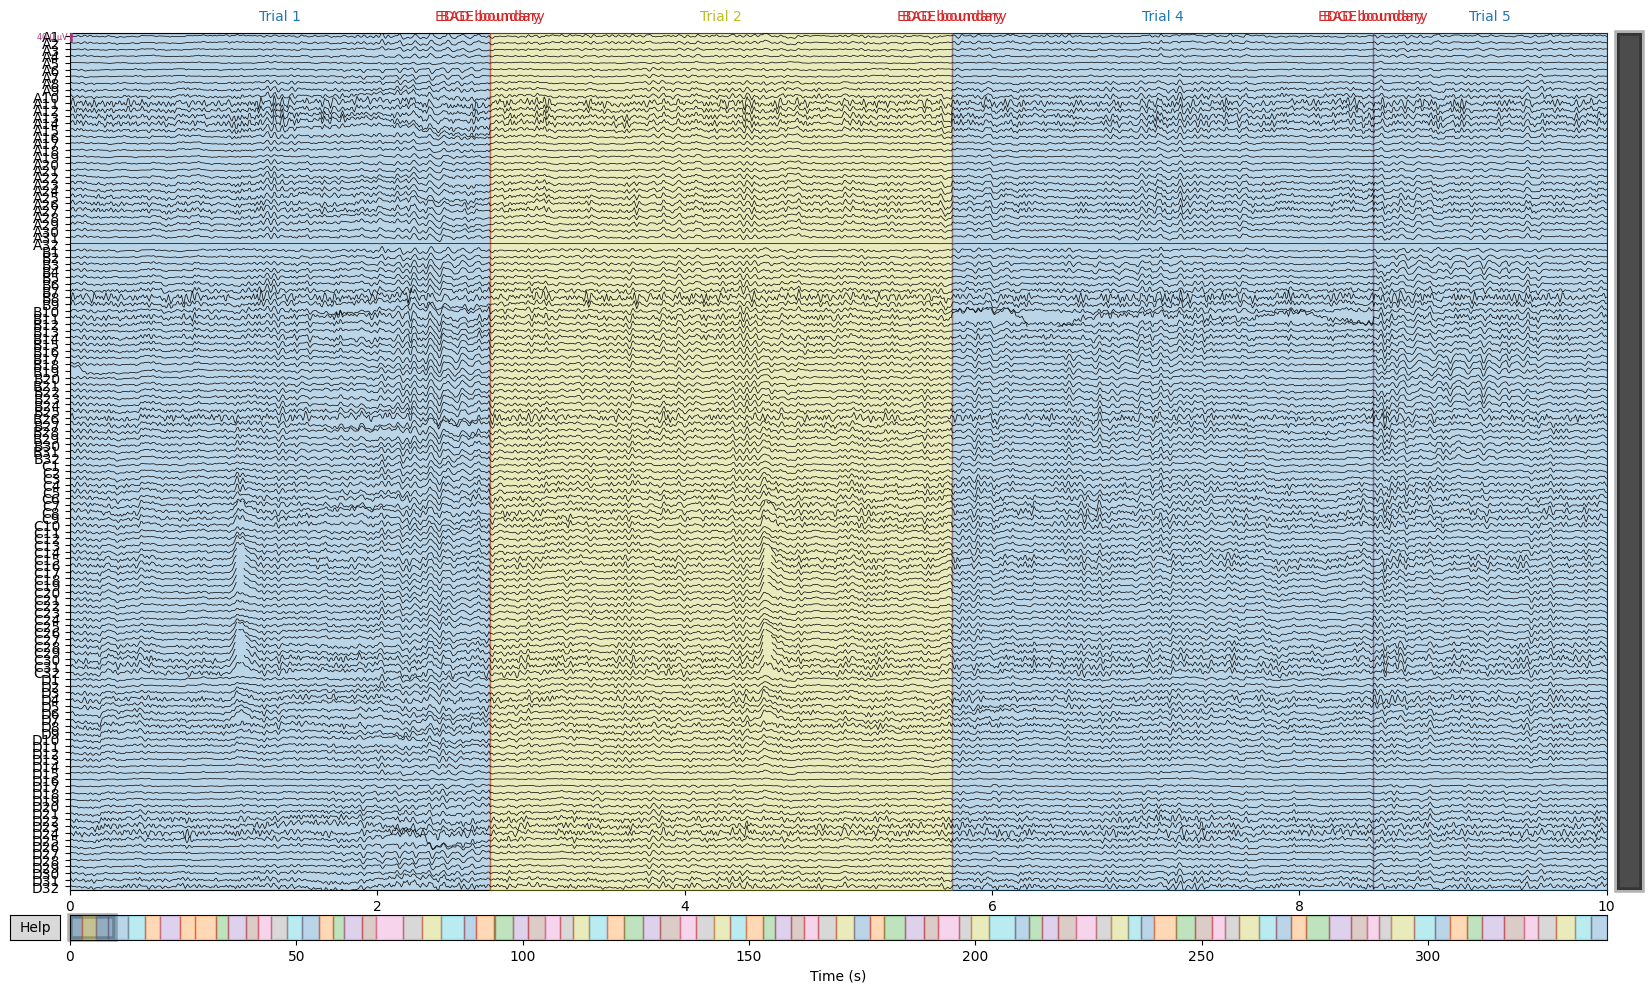

In [32]:
%matplotlib qt 
new_raw.plot(picks = 'eeg' , n_channels=128,duration = 10 )

Text(0.5, 1.0, 'Distribution of Trial Lengths')

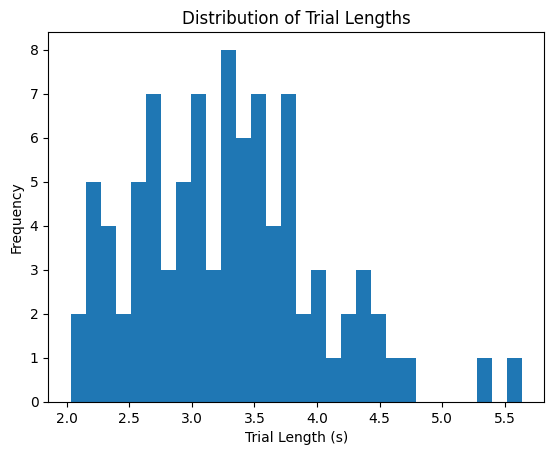

In [29]:
%matplotlib inline
all_lengths = []
for idx, row in all_events.iterrows():
    Tnum = row['Trial']
    length = row['Respons'] - row['defOnset']
    all_lengths.append(length)
all_lengths = np.array(all_lengths)
# Plot the distribution of trial lengths
plt.figure()
plt.hist(all_lengths, bins=30)
plt.xlabel('Trial Length (s)')
plt.ylabel('Frequency')
plt.title('Distribution of Trial Lengths')  
